In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math as m
import os
from multiprocessing import Pool
import random as rd
from pathlib import Path
import sys
from scipy.integrate import simps
import itertools


In [2]:
def Product(variables):
    return list(itertools.product(*variables))

def data_reader(simulation,folder_i,file_j):
  #  print("core = " ,folder_i , "run = ", file_j)
    folder = simulation + str(folder_i) + '/'

    str_j = str(file_j)
    file_name_y = str_j + "y.csv"
    data_y = pd.read_csv('../../c++/pedsim/traj_files/'+ simulation+ "/" + folder + file_name_y, sep=",", header=0)
    lattice_y = np.array(data_y)
    #print(lattice_y.shape)
    return lattice_y


def flow_calc(lattice_y,fps,time_int,n):
    flow_list = []
    time_int_measure = time_int
    t_array = np.arange(0,lattice_y.shape[0] - time_int_measure, time_int_measure)

    ly0 = lattice_y[0:-1]
    ly1 = lattice_y[1:]
    flow_list = np.array([np.array([1  for ly0_ii,ly1_ii in zip(ly0_i, ly1_i) if (ly0_ii>0 and ly1_ii < 0)]).sum() for ly0_i,ly1_i in zip(ly0,ly1)])
    flow_plot = np.array([flow_list[k:k+n].sum() for k in t_array])
    return flow_plot

def exit_times_fetch(lattice_y,sim_time_array,fps,time_int,n,stat_state):
    flow_list = []
    exit_times = []
    time_int_measure = time_int
    t_array = np.arange(0,lattice_y.shape[0] - time_int_measure, time_int_measure)
    ly0 = np.array(lattice_y[0:-1])
    ly1 = np.array(lattice_y[1:])
    flow_list = np.array([np.array([1 for ly0_ii,ly1_ii in zip(ly0_i, ly1_i) if (np.isnan(ly0_ii) - 1 and np.isnan(ly1_ii ))]).shape[0] for ly0_i,ly1_i in zip(ly0,ly1)])
    t_i = 0
    for flow in flow_list[:sim_time_array.shape[0]]:
        if (flow > 0 and sim_time_array[t_i] > stat_state):
            exit_times.append(sim_time_array[t_i])
        t_i += 1
    exit_times = np.array(exit_times)
    exit_times_diff = exit_times[1:] - exit_times[0:-1]
    return exit_times_diff

def kaplan_meier_estimator(exit_times_diff):
    exit_times_diff_sort = np.sort(exit_times_diff)
    max_time_diff = exit_times_diff_sort.max()
    n_i = exit_times_diff_sort.shape[0]
    survival_list = []
    d_i = 0
    t_old = 0
    survival = 1
    t_inc = 0.1
    time = np.arange(0,max_time_diff,t_inc)
    survival_list = []
    for t in time:
        t_i = t_old
        while t_i < t:
            d_i += 1
            t_i += t_inc
            survival *= (1 - d_i/n_i)
        survival_list.append(survival)
        t_old = t
    return np.array(survival_list), time
    

def multi_analysis(simulation,folder_i,file_j,time_array,fps,time_int,n,stat_state,anal_type = "none"):
    lattice_y = data_reader(simulation,folder_i,file_j)
    if anal_type == "flow" or anal_type =="all":
        flow_plot = flow_calc(lattice_y,fps,time_int,n)
        return flow_plot #exit_times 
    if anal_type == "exit_diff" or anal_type =="all":
        exit_times = exit_times_fetch(lattice_y,time_array,fps,time_int,n,stat_state)
        return exit_times
    if anal_type == "survival" or anal_type =="all":
        survival = kaplan_meier_estimator(exit_times)
        return survival
    if anal_type == "none":
        print("anal_type needs specifcation which analysis to perform. choose 'flow' for flow, 'exit_diff' for difference in exit times, 'survival' for a survival plot of exit time differneces or 'all' for all mentioned")

def exit_times_flat(exit_times):
    exit_times_diff_flat = np.empty(0)
    for etd in np.array(exit_times).flatten():
        exit_times_diff_flat = np.append(exit_times_diff_flat,np.array(etd))
    return exit_times_diff_flat
def exit_times_plot(exit_times_diff_flat):
    x,bins, p = plt.hist(exit_times_diff_flat,bins = 500,density =True)
    plt.xscale('log')
    #plt.xscale('log')
    plt.show()


In [3]:
def max_frame_fetch(traj):
    return  traj['FR'].max()

def lattice_data(traj):
    max_id = traj['#ID'].max()
    max_frame = traj['FR'].max()
    #print("max_frame = ", max_frame)
    data_x_new = []
    data_y_new = []
    data_id_new = []
    data_frames_new = []
    data_angle_new = []
    for id_ped in np.arange(1, max_id + 1):
        x_i = np.array(traj[traj['#ID'] == id_ped]['X'])
        x_f = np.array(traj[traj['#ID'] == id_ped]['FR'])
        y_i = np.array(traj[traj['#ID'] == id_ped]['Y'])
        angle_i = np.array(traj[traj['#ID'] == id_ped]['ANGLE'])

        if x_i.shape[0] < max_frame:
            diff = max_frame - x_i.shape[0]
            x_nan = [np.nan for i in np.arange(0, diff)]
            x_i = np.append(x_i, x_nan)
            y_i = np.append(y_i, x_nan)
            angle_i = np.append(angle_i, x_nan)
            x_f = np.append(x_f, np.arange(x_f[-1] + 1, x_f[-1] + diff + 1))
            x_id = [id_ped for i in np.arange(0, x_i.shape[0])]
        else:
            x_id = np.array(traj[traj['#ID'] == id_ped]['#ID'])  # deletes the last frame of the person with maximal frames saved to unify the length of all frames
            x_id = x_id[0:-1]
            x_i = x_i[0:-1]
            angle_i = angle_i[0:-1]

            x_f = x_f[0:-1]
            y_i = y_i[0:-1]
        data_x_new = np.append(data_x_new, x_i)
        data_id_new = np.append(data_id_new, x_id)
        data_frames_new = np.append(data_frames_new, x_f)
        data_y_new = np.append(data_y_new, y_i)
        data_angle_new = np.append(data_angle_new, angle_i)
    #print("data_x_new", data_x_new.shape)
    trajectory_dic = {'id': data_id_new, 'frame': data_frames_new, 'x': data_x_new, 'y': data_y_new, 'angle': data_angle_new}
    traj_frame = pd.DataFrame(trajectory_dic)
    x_dic = {}
    y_dic = {}
    angle_dic = {}
    x_col_old_shape = 0
    #print("check befor the loop for id 99 ", traj_frame[traj_frame['id'] == 99]['x'])
    for i in np.arange(1, max_id+1):
        x_col = np.array(traj_frame[traj_frame['id'] == i]['x'])
        y_col = np.array(traj_frame[traj_frame['id'] == i]['y'])
        angle_col = np.array(traj_frame[traj_frame['id'] == i]['angle'])
        #if x_col_old_shape != x_col.shape[0]:
            #print(x_col.shape[0],x_col_old_shape)
            #print("id = ", i," wit shape ", x_col.shape[0])
         #   print(x_col)
        x_col_old_shape = x_col.shape[0]
        
        if x_col.shape[0] != max_frame:
            
            print("WARNING: x_col was not appended to shape max frame. x_col shape = ", x_col.shape, "max_frame = ", max_frame)
            diff = max_frame - x_col.shape[0]
            print("diff = ", diff)
            x_nan = [np.nan for i in np.arange(0, diff)]
            print(x_nan)
            x_col = np.append(x_col, x_nan)
            print("x_col_shape ",x_col.shape, "max_frame = ", max_frame)
            if x_col_old_shape == y_col.shape[0]:
                print("WARNING: y_col was not appended to shape max frame. x_col shape = ", y_col.shape, "max_frame = ", max_frame)
                y_col = np.append(y_col, x_nan)
            
        #print("before map shapes," ,x_col.shape, y_col.shape)

        x_dic[i] = x_col
        y_dic[i] = y_col
        angle_dic[i] = angle_col
    traj_x_frame = pd.DataFrame(x_dic)
    traj_y_frame = pd.DataFrame(y_dic)
    traj_angle_frame = pd.DataFrame(angle_dic)
 
    return traj_x_frame, traj_y_frame, traj_angle_frame


In [4]:
def analyser(simulation,max_file,fps,file_number_start, max_folder,max_time, N_ped,door_width,stat_state  ,n,anal_type):
    flow_array = []

    #file_number_start = 0 #initial folder number
    time_int = int(1*fps) #intervall in which the flow is measured
    time_int_measure = time_int# intervall in which the flow is measured
    #max_folder = 16# max number of folders
    #max_file = 10 #max number of files
    #max_time = 3000 #max time of the simulation
    stat_state = 50 #time when the stationary state is reached
    threads = max_folder #how many threads does pool use
    
    folder_i = 0
    str_j = str(0) #initial file number
    folder = simulation + str(folder_i) + '/' #folder name
    file_name_y = str_j + "y.csv" # file name


    data_y = pd.read_csv(simulation, sep=",", header=0) 
    lattice_y = np.array(data_y)
    t_array = np.arange(0,lattice_y.shape[0] - time_int_measure, time_int_measure)
    for sim_t_max in max_time:
        exit_times = np.empty(0)

        sim_time_array = np.arange(0,sim_t_max,1/fps)
        #print(sim_time_array.shape)
        for file_j in np.arange(0,max_file):
            print("calculation is at ", file_j ,'/', max_file-1 )
           # print("file =", file_j)
            #print("<pool>")
            pool = Pool(processes=threads)
            g_pool = np.array([pool.apply_async(multi_analysis, args=(simulation,folder_i,file_j,sim_time_array,fps,time_int,n,stat_state,anal_type)) for folder_i in np.arange(0,max_folder)])
            flow_plot = np.array([p.get() for p in g_pool])
            pool.close()
            #print("</pool>")
            #exit_times = np.append(exit_times,flow_plot)
            flow_array.append(flow_plot)
    return flow_array, t_array

In [5]:
def densty1d(delta_x, a):
    return np.array(list(map(lambda x: 1 / (m.sqrt(m.pi) * a) * m.e ** (-x ** 2 / a ** 2), delta_x)))


def normal(lattice_x, lattice_y, x_array, y_array, a):
    x_dens = np.array(
        [lattice_x - x for x in x_array])  # calculate the distant of lattice pedestrians to the measuring lattice
    y_dens = np.array([lattice_y - y for y in y_array])

    rho_matrix_x = np.array([densty1d(delta_x, a) for delta_x in x_dens])  # density matrix is calculated
    rho_matrix_y = np.array([densty1d(delta_y, a) for delta_y in y_dens])
    rho_matrix = np.matmul(rho_matrix_x, np.transpose(rho_matrix_y))
    return rho_matrix.mean()

def b_data_name(b,dig):
    b = round(b,dig)
    str_b = ''
    for let in str(b):
        if (let in '.'):
            str_b += '_'
        else:
            str_b += let
    return str_b

In [6]:
def exit_times_fetch(lattice_y,sim_time_array,fps,time_int,stat_state):
    flow_list = []
    exit_times = []
    t_array = np.arange(0,lattice_y.shape[0] - time_int, time_int)
    ly0 = np.array(lattice_y[0:-1])
    ly1 = np.array(lattice_y[1:])
    flow_list = np.array([np.array([1 for ly0_ii,ly1_ii in zip(ly0_i, ly1_i) if (ly0_ii>-0.19 and ly1_ii < -0.19)]).shape[0] for ly0_i,ly1_i in zip(ly0,ly1)])
    t_i = 0
    for flow in flow_list[:sim_time_array.shape[0]]:
        if (flow > 0 and sim_time_array[t_i] > stat_state):
            exit_times.append(sim_time_array[t_i])
        t_i += 1
    exit_times = np.array(exit_times)
    exit_times_diff = exit_times[1:] - exit_times[0:-1]
    return exit_times_diff

In [37]:
sl = "/"
path = pd.read_csv("path.csv")
path = path['path'][0]

folder_frame = pd.read_csv(path + "folder_list.csv")
folder_list = np.array(folder_frame['ini_folder'])
variables = pd.read_csv(path + "variables_list.csv")

folder = "trajectories/"

b_frame = pd.read_csv(path + "b_list.csv")
#rho_ini_frame = pd.read_csv(path + "rho_ini.csv")
#rho_ini = np.array(rho_ini_frame['rho_ini'])
T_frame = pd.read_csv(path + "T_list.csv")
T = np.array(T_frame['T'])
esigma_frame = pd.read_csv(path + "esigma.csv")
esigma = np.array(esigma_frame["esigma"])
v0_frame = pd.read_csv(path + "v0_list.csv")
v0 = np.array(v0_frame['v0'])
N_runs = variables['N_runs'][0]
fps = variables['fps'][0]
b = np.array(b_frame['b'])
N_ped = variables['N_ped'][0]
t_max = variables['t_max'][0]
test_var = variables['test_var'][0]
cross_var = Product(np.array([esigma,b,v0,T])) 
print("b/2 = ", b)
print("fps = " ,fps)
print("N_runs = ", N_runs)
print("folder_list_0", folder_list[0])
print("folder_list_-1", folder_list[-1])
print("N_ped = ", N_ped)
print("t_max = ", t_max)
if test_var == 0:
    print("test variable esigma")
if test_var == 1:
    print("test variable b")
if test_var == 2:
    print("test variable v0")
print(cross_var)
"""print("writing files")
for i in range(N_runs):
    #location = np.array([["evac_traj_" +b_data_name(2 * bi,3) + "_"+ str(i) +".txt" for bi in b] for esig in esigma])
    location = np.array(["evac_traj_" +b_data_name(2 * var[1],3) + "_"+ str(i) +".txt" for var in cross_var])

    #location = location.flat
    for loc,run_folder in zip(location, folder_list):
        file_name = folder  + run_folder + sl +loc
        if os.path.isfile(file_name):
            file = open(file_name, 'r')
            line_count = 0
            new_file = open(folder  + run_folder+ sl + "new_" + loc ,'w')
            #print(loc)
      
            for line in file:
                line_count+= 1
                if line_count > 10:
                    new_file.write(line)
            os.system("rm " + folder  + run_folder + sl +loc)
            new_file.close()
        else:
            print("WARNING: file " + file_name + " not found")
print("/writing files")"""




b/2 =  [0.6]
fps =  16
N_runs =  1
folder_list_0 ini_hm_N_ped54_tmax600_size_0_17_fps_16_testvar_v0/ini_0_6_hm_54_esigma_0_5_tmax_600_periodic_1_v0_1_3_T_0_4
folder_list_-1 ini_hm_N_ped54_tmax600_size_0_17_fps_16_testvar_v0/ini_0_6_hm_54_esigma_0_5_tmax_600_periodic_1_v0_2_3_T_0_4
N_ped =  54
t_max =  600
test variable v0
[(0.5, 0.6, 1.3, 0.4), (0.5, 0.6, 1.5, 0.4), (0.5, 0.6, 1.7, 0.4), (0.5, 0.6, 1.9, 0.4), (0.5, 0.6, 2.1, 0.4), (0.5, 0.6, 2.3, 0.4)]


'print("writing files")\nfor i in range(N_runs):\n    #location = np.array([["evac_traj_" +b_data_name(2 * bi,3) + "_"+ str(i) +".txt" for bi in b] for esig in esigma])\n    location = np.array(["evac_traj_" +b_data_name(2 * var[1],3) + "_"+ str(i) +".txt" for var in cross_var])\n\n    #location = location.flat\n    for loc,run_folder in zip(location, folder_list):\n        file_name = folder  + run_folder + sl +loc\n        if os.path.isfile(file_name):\n            file = open(file_name, \'r\')\n            line_count = 0\n            new_file = open(folder  + run_folder+ sl + "new_" + loc ,\'w\')\n            #print(loc)\n      \n            for line in file:\n                line_count+= 1\n                if line_count > 10:\n                    new_file.write(line)\n            os.system("rm " + folder  + run_folder + sl +loc)\n            new_file.close()\n        else:\n            print("WARNING: file " + file_name + " not found")\nprint("/writing files")'

ValueError: too many values to unpack (expected 2)

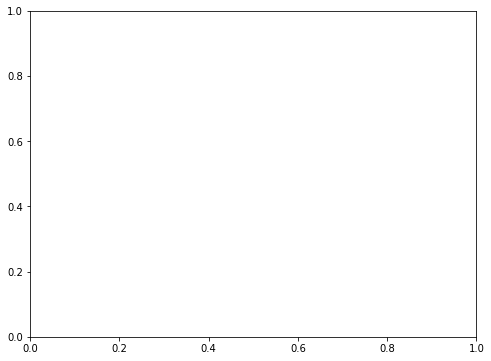

In [8]:



file_path = "../../expdata/"
fps_n = 0
t_min = 0
t_max = 0
fps = 16


for bi, ini in zip(b,folder_list):
    fig, ax = plt.subplots(1, figsize=(8, 6))

    location = "new_evac_traj_" + b_data_name(2 * bi,3)
    max_frame = 0
    exit_diff_list = np.empty(1)

    for i in range(N_runs):
        loc = folder + ini + sl + location + "_" + str(i) + ".txt"
        #print(loc)
        traj = pd.read_csv(loc, sep="\s+", header=0)
        l_x, l_y = lattice_data(traj)
        t_array = np.array([i/fps for i in range(np.array(l_y).shape[0] )])
        exit_diff = exit_times_fetch(l_y,t_array,fps,1,150)
        exit_diff_list = np.append(exit_diff_list, exit_diff)
    exit_diff_array = np.array(exit_diff_list)
    exit_diff_array = exit_diff_array.flatten('C')
    plt.hist(exit_diff_array,bins = 250,density=True)
    plt.show()
    plt.hist(exit_diff_array,bins = 250,density=True)
    plt.yscale("log")
    plt.show()

In [ ]:
#b = np.array([1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.2,2.4,2.6,3.,3.4,4.5,5.6])

for i in range(b.shape[0]):
    location = "new_evac_traj_" + b_data_name(2 * b[i],3)
    loc = folder + folder_list[i] + sl + location + "_" + str(0) + ".txt"
    traj = pd.read_csv(loc, sep="\s+", header=0)
    l_x, l_y,angle = lattice_data(traj)
    print(b[i])
    plt.plot(l_x[fps * 5:fps * 30],l_y[fps * 5:fps * 30])
    plt.xlim([-2.5,2.5])
    plt.ylim([-1,6])
    plt.show()


In [ ]:
"""
path = "trajectories/" + "ini_lm_" + str(N_ped) + sl 
dig = 3
frequency_list = []
max_frame_list = []
for bi in b:
    frequency_list_b = []
    max_frame_list_b = []
    for esig in esigma:
        count = 0
        max_frame_list_i = []
        for i in range(N_runs):
            loc = "ini_"+ b_data_name(bi,dig) + "_lm_" + str(N_ped) + "_rho_" + b_data_name(float(rho_ini[0]),dig) + "_esigma_" + b_data_name(esig,dig) + sl
            traj_file = "new_evac_traj_" + b_data_name(2 * bi,3) + "_" + str(i)+".txt"
            traj = pd.read_csv(path + loc + traj_file, sep="\s+", header=0)
            print(loc + traj_file)
            l_x, l_y = lattice_data(traj)
            max_frame_list_i.append(l_x.shape[0])
            if(l_x.shape[0] == max_time):
                count += 1
        max_frame_list_b.append(np.array(max_frame_list_i))
        frequency_list_b.append(count/N_runs)
    max_frame_list.append(max_frame_list_b)
    frequency_list.append(frequency_list_b)
max_frame_array = np.array(max_frame_list)
mean_max_frame = max_frame_array.mean(axis=2)
    """

In [ ]:
"""fig, ax = plt.subplots(1, figsize=(8, 6))


for max_frame,bi in zip(mean_max_frame,b):
    plt.scatter(esigma,max_frame/fps, label = "b = " + str(2 * bi))
#plt.xscale("log")
#plt.yscale("log")
ax.legend(loc="upper right", title="b in [m]", frameon=False)
plt.xlabel("sigma")
plt.ylabel("time to evacuate")
plt.savefig("plots/time_evac_b_" + str(2 * b[0]) + ".pdf")
plt.show()
#plt.xscale("log")
#plt.yscale("log")
fig, ax = plt.subplots(1, figsize=(8, 6))

for frequency,bi in zip(frequency_list,b):
    plt.scatter(esigma,frequency, label = "b = " + str(2 * bi))
ax.legend(loc="upper right", title="b in [m]", frameon=False)
plt.xlabel("sigma")
plt.ylabel("fraction of not all evacuated in 100 sec")
plt.savefig("plots/frac_evac_" + str(2 * b[0]) + ".pdf")
plt.show()

plt.scatter(esigma,frequency_list[3])
"""

In [ ]:
def s(t,s1,s2,p):
    vec = s1 + t * (s2-s1) - p
    vec_leng = np.sqrt((vec * vec).sum())
    if vec_leng > 0:
        return vec/vec_leng
    else:
        return np.array([0,0])
def min_t(p,s1,s2):
    p1 = p-s1
    p2 = s2-s1
    p_mul = p1*p2
    p_skal = p_mul.sum(axis=1)
    leng = (s2-s1)**2
    leng = leng.sum()
    t_list = p_skal/leng
    u = np.array([s(min(max(t,0),1),s1,s2,pi) for t,pi in zip(t_list,p)])
    return u

In [ ]:
traj = pd.read_csv("trajectories/" + folder_list[0] + "/new_evac_traj_" + b_data_name(2 * bi,3) + "_" + str(0) + ".txt", sep="\s+", header=0)
l_x, l_y, angle = lattice_data(traj)
print("combine")
l_x = np.array(l_x)
l_y = np.array(l_y)
s1 = np.array([0.4,0])
s2 = np.array([-0.4,0])

lattice = np.array([np.vstack((l_xi, l_yi)).T for l_xi,l_yi in zip(l_x,l_y)])
print(lattice.shape)
#print(lattice[0])
u = np.array([min_t(lat,s1,s2)  for lat in lattice])
print("/combine")
#ex = np.array([np.cos(angle_i * rad_trans) if angle_i < 0 else np.cos(abs(angle_i * rad_trans) + pi) for angle_i in theta])
#ey = np.array([np.sin(angle_i * rad_trans) if angle_i < 0 else np.sin(abs(angle_i * rad_trans) + pi) for angle_i in theta])
#e = np.array([[np.cos(angle_i * rad_trans),np.sin(angle_i * rad_trans)] if angle_i < 0 else [np.cos(abs(angle_i * rad_trans) + pi) , np.sin(abs(angle_i * rad_trans) + pi)] for angle_i in theta])
#u = np.array([[s(min_t(np.array([xi,yi]),s1,s2),s1,s2) - np.array([xi,yi]) for xi,yi in zip(x,y)] for x,y in zip(np.array(l_x),np.array(l_y))])




In [ ]:
a = np.random.rand(3,2)
b = np.random.rand(3,2)
print(a*b)
print(np.dot(a,b.T).trace())
print((a*b).sum(axis=1).sum())

In [ ]:
folder_frame = pd.read_csv("folder_list.csv")
b = np.array(b_frame['b'])
pol_b = []
aline_b = []
s1 = np.array([0.4,0])
s2 = np.array([-0.4,0])


    
for folder,bi in zip(folder_list,b):
    traj = pd.read_csv("trajectories/" + folder + "/new_evac_traj_" + b_data_name(2 * bi,3) + "_" + str(0) + ".txt", sep="\s+", header=0)
    l_x, l_y, angle = lattice_data(traj)
    
    l_x = np.array(l_x)
    l_y = np.array(l_y)
    s1 = np.array([0.4,0])
    s2 = np.array([-0.4,0])
    lattice = np.array([np.vstack((l_xi, l_yi)).T for l_xi,l_yi in zip(l_x,l_y)])
    u = np.array([min_t(lat,s1,s2)  for lat in lattice])

    angle = np.array(angle)
    print("corridor width = ", 2 * bi)
    fig, ax = plt.subplots(1, figsize=(8, 6))
    pi = 3.1415
    full_angle = 360
    rad_trans = 2 * pi/full_angle
    time =   fps * 240
    mean_frames = int(fps * 0.5)
    angle_5sek = angle[time:time + mean_frames].mean(axis=0)
   # print(angle_5sek.shape)
    l_x_5sek = np.array(l_x)[time:time + mean_frames].mean(axis=0)
    l_y_5sek = np.array(l_y)[time:time + mean_frames].mean(axis=0)
    ex = np.array([np.cos(angle_i * rad_trans) if angle_i < 0 else np.cos(abs(angle_i * rad_trans) + pi) for angle_i in angle_5sek])
    ey = np.array([np.sin(angle_i * rad_trans) if angle_i < 0 else np.sin(abs(angle_i * rad_trans) + pi) for angle_i in angle_5sek])
    
    
    #polarisation
    aline_sum = 0
    e_pol = 0
    count = 0
    stat_state = 200 * fps
    for theta in angle[stat_state:]:
        e = np.array([[np.cos(angle_i * rad_trans),np.sin(angle_i * rad_trans)] if angle_i < 0 else [np.cos(abs(angle_i * rad_trans) + pi),np.sin(abs(angle_i * rad_trans) + pi)]for angle_i in theta])
        e_pol += e.sum(axis=0)/N_ped
        aline_sum += np.dot(e,u[count+ stat_state].T).trace() / N_ped
        count += 1
    pol = np.sqrt((e_pol * e_pol).sum())
    pol_b.append(pol/count)
    aline_b.append(aline_sum/count)
    ############
    #v_array = np.array([[ex_i,ey_i] for ex_i,ey_i in zip(ex,ey)])
    #print(l_x_5sek.shape)
    plt.xlim([-3,3])
    plt.ylim([-1,6])
    plt.quiver(l_x_5sek,l_y_5sek, ex, ey, scale=21)
    plt.scatter(l_x_5sek,l_y_5sek)
    plt.show()


In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 6))
plt.scatter(b*2,pol_b)

plt.yscale("log")
plt.xscale("log")
plt.ylabel("polarisation")
plt.xlabel("b in [m]")
plt.savefig("plots/polarisation_lm.pdf")
plt.show()

fig, ax = plt.subplots(1, figsize=(8, 6))
plt.scatter(b*2,aline_b)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("alignement")
plt.xlabel("b in [m]")
plt.savefig("plots/polarisation_lm.pdf")

plt.show()

In [ ]:
density_mean = []
density = []
dens_folder = "density_runs"
dens_folder_run = "density_" + str(N_ped) + "_" + str(t_max)
os.system('mkdir ' + path +dens_folder)


In [ ]:
#path = "../../../files/evacuation_files/trajectories/"



for bi, ini in zip(b,folder_list):
    location = "new_evac_traj_" + b_data_name(2 * bi,3)
    density_runs = []
    max_frame = 0
    for i in range(N_runs):
        loc = folder + ini + sl + location + "_" + str(i) + ".txt"
        print(loc)
        traj = pd.read_csv(loc, sep="\s+", header=0)
        frame = max_frame_fetch(traj)
        if frame > max_frame:
            max_frame = frame
    
    density_run = []
    density_runs_map = {}

    for i in range(N_runs):
        loc = folder + ini + sl + location + "_" + str(i) + ".txt"
        print(loc)
        traj = pd.read_csv(loc, sep="\s+", header=0)
        l_x, l_y = lattice_data(traj)
        
        fwhm = 0.4
        a = fwhm * m.sqrt(2) / (2 * m.sqrt(2 * m.log(2)))
        lattice_x = np.array(l_x)
        lattice_y = np.array(l_y)
        x_array = np.linspace(-0.5,0.5,50)
        y_array = np.linspace(0.5,1.5,50)
        print("*****************<calc density>*****************")
        lat_x_no_nan = []
        lat_y_no_nan = []

        for lat_x,lat_y in zip(lattice_x,lattice_y):
            l_x_no_nan = [x  for x in lat_x if np.isnan(x) == False]
            l_y_no_nan = [y  for y in lat_y if np.isnan(y) == False]
            lat_x_no_nan.append(l_x_no_nan)
            lat_y_no_nan.append(l_y_no_nan)

        #dens_run = normal(lat_x_no_nan,lat_y_no_nan,x_array,y_array,a)
        print("    *****************<pool>*********************")
        pool = Pool()
        g_pool = np.array([pool.apply_async(normal, args=(l_x_no_nan,l_y_no_nan,x_array,y_array,a)) for l_x_no_nan, l_y_no_nan in zip(lat_x_no_nan, lat_y_no_nan)])
        density_run = [p.get() for p in g_pool]
        pool.close()
        print("    *****************</pool>********************")
        print("*****************</calc density>****************")
        
        dens_run_shape = np.array(density_run).shape[0]
        #print(dens_run_shape.shape[0],max_frame)
        print(np.array(density_run).shape)
        

        if dens_run_shape < max_frame:
            diff = int(max_frame-dens_run_shape)
            #print(diff)
            nod_list = [0 for i in np.arange(0,diff)]
            density_run = np.append(density_run,nod_list)
        #print(np.array(density_run).shape,max_frame)
        density_runs_map[str(i)] = density_run

        density_runs.append(np.array(density_run))
        #plt.plot(density_run)
    #plt.show()
    mean_runs_dens = np.array(density_runs).mean(axis=0)
    std_runs_dens = np.array(density_runs).std(axis=0)
    density.append(mean_runs_dens)
    dens_i_df = pd.DataFrame(density_runs_map)
    dens_i_df.to_csv(path + dens_folder  + "/" +"densities_N_ped_" +str(N_ped) + "_b_" + str(int(200 * bi)) + "_tmax_" + str(t_max) +"_N_runs_"+ str(N_runs) + ".csv")
    print("density shape = ", np.array(density).shape)
            #time = np.arange(0,59.2,0.1)
    #density_sat_state = np.array(mean_runs_dens[int(fps * 5):int(fps*10)])
    #print(density_sat_state.shape)
    #density_mean.append(density_sat_state.mean())



In [ ]:
#print(std_runs_dens)
dens_map = {}

b = np.array(b_frame['b'])
density1 = np.array(density)
shape_max = 0
for d in density1:
    #print(d.shape)
    shape = d.shape[0]
    if shape > shape_max:
        shape_max = shape
#print(shape_max)
count = 0
for d in density1:
   # print(d.shape[0])
    if d.shape[0] < shape_max:
        diff = int(shape_max-d.shape[0])
        #print("differenz = ", diff)
        nod_list = [0 for i in np.arange(0,diff)]
        d = np.append(d,nod_list)
        density1[count] = d
    count+=1
    #print(density1.shape[0])  
count = 0

t = np.arange(0,2501/25,1/25)
for d,bi in zip(density1,b):
    #print(bi)
    #bi = round(bi,3)
    plt.plot(d)
    count += 1
    dens_map[str(count) + "," +str(bi)] = d
    

dens_frame = pd.DataFrame(dens_map)
dens_frame.to_csv(path + dens_folder + 'dens_mean_Nped_' +str(N_ped) + "_b_" + str(int(200 * bi)) + "_tmax_" + str(t_max) +"_N_runs_"+ str(N_runs) + ".csv")
#plt.show()

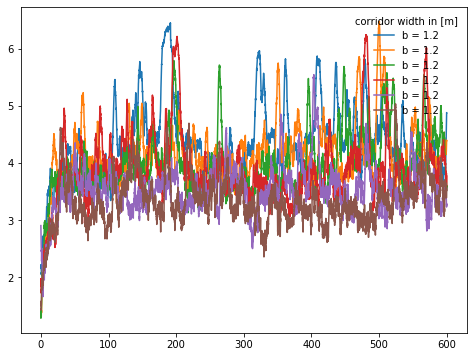

No handles with labels found to put in legend.


fps =  16
array_min/max =  2400 9600
(43200,)
(43200,)


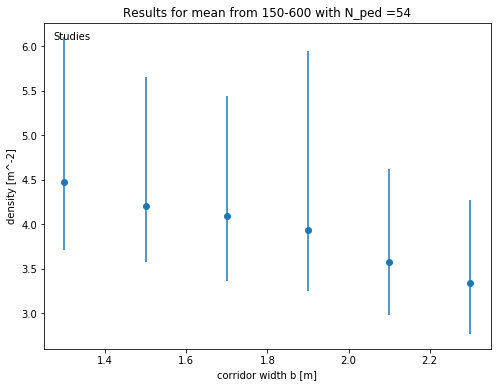

In [42]:
den = []
std = []
den2 = []
#rho_ini = np.array(rho_ini_frame['rho_ini'])
b_max = b.max()
b_min = b.min()
var = cross_var[-1]
#density_pd = pd.read_csv(path  + 'dens_mean_Nped_' +str(N_ped) + "_b_" + str(int(200 * b[-1]))+"_v0_" +str(int(100*v0[-1])) + "_tmax_" + str(t_max) +"_N_runs_"+ str(N_runs) + ".csv")
density_pd = pd.read_csv(path + 'dens_mean_Nped_' +str(N_ped) + "_b_" + str(int(200 * var[1]))+"_v0_" +str(int(100*var[2]))+ "_T_" + str(int(100 * var[3]))  + "_tmax_" + str(t_max) +"_N_runs_"+ str(N_runs) + ".csv")
density_np = []
for key_b , key_count in zip(cross_var,np.arange(1,np.array(cross_var).shape[0] + 1)):
    key_b = round(key_b[2],3)
    #print(key_b)
    density_np.append(density_pd[str(key_count)  + ',' + str(key_b)])

density_np = np.array(density_np)
density_hist = density_np



fig, ax = plt.subplots(1, figsize=(8, 6))

for d,var in zip(density_np,cross_var):
    #print(bi)
    #print(d.shape)
    t_array = [i/fps for i in range(d.shape[0] )]
    #bi = round(bi,3)
    plt.plot(t_array,d, label = "b = " + str(2*var[1]))
ax.legend(loc="upper right", title="corridor width in [m]", frameon=False)

plt.savefig("plots/density_time_series_N_ped_" + str(N_ped) + ".pdf")
plt.show()
#plt.plot(density_pd['1.5'])
#plt.plot(density_pd['1.35'])

#print(density_np[0].shape)
#print(np.array(density)[0].mean())
fig, ax = plt.subplots(1, figsize=(8, 6))
print("fps = ", fps)
min_t = 150
max_t = 600
array_min = min_t * fps
array_max = max_t * fps
print("array_min/max = ", array_min,array_max)
df = pd.DataFrame()
density_reduced = np.array([[den for den in dens[array_min:array_max]] for dens in density_np])
cat = np.array([np.array([i for k in den]) for i,den in zip (np.arange(0,np.array(cross_var).shape[0]),density_reduced)])
#print(cat.flatten().shape)
#print(density_reduced.flatten().shape)
print(cat.flatten().shape)
print(density_reduced.flatten().shape)
df['category'] =  cat.flatten()
df['density'] = density_reduced.flatten()

mean = df.groupby('category')['density'].mean()
p025 = df.groupby('category')['density'].quantile(0.025)
p975 = df.groupby('category')['density'].quantile(0.975)

plt.xlabel('corridor width b [m]')
plt.ylabel('density [m^-2]')
"""

plt.scatter([1.2,2.3,3.4,4.5,5.6],[2.3,3.8,4.,4.3,4.2], label = "Simulation results Ben Hein", color = "orange")
"""




exp_dens = pd.read_csv("exp_results/exp_data.csv")
b22 = [1.2,2.3,3.4,4.5,4.5,5.6]

p1 = np.array(exp_dens['p025'])
p2 = np.array(exp_dens['p975'])
mean_exp =  np.array(exp_dens['mean'])

if test_var == 0:
    plt.errorbar(esigma,mean,yerr=[mean - p025, p975 - mean],fmt='o')
if test_var == 1:
    plt.errorbar(2*b,mean,yerr=[mean - p025, p975 - mean],fmt='o')
    plt.errorbar(b22,mean_exp,yerr =[mean_exp - p1, p2 - mean_exp], label = "Experimental results Juliane Adrian", color = "r",fmt='o')

if test_var == 2:
    plt.errorbar(v0,mean,yerr=[mean - p025, p975 - mean],fmt='o')

plt.title("Results for mean from " + str(min_t) + "-" + str(max_t) + " with N_ped =" + str(N_ped))
ax.legend(loc="upper left", title="Studies", frameon=False)
#plt.boxplot(, positions=[2,4,5.5])


#plt.scatter(2*b,den2)
#plt.yscale('log')
#plt.xscale('log')

df_results = pd.DataFrame()
df_results['mean'] = mean
if test_var == 0:
    df_results['esigma'] = esigma
if test_var == 1:
    df_results['b'] = b
if test_var == 2:
    df_results['v0'] = v0
df_results['p975'] = p975 
df_results['p025'] = p025 

df_results.to_csv("mean/results.csv")
mean.to_csv
plot_name = "plots/density/" +  "dens_Nped_" + str(N_ped)+"_time_int_mean_" + str(min_t) + "-" + str(max_t) + "_Nruns_" + str(N_runs) + "_fps_" + str(fps) + "_brange_" + str(b_min) + "_" + str(b_max) + ".pdf" 
plt.savefig(plot_name)

plt.show()

In [ ]:
a =  15.37 
c = -10.31 
linear_tan = [np.log(2/(1 - (dens - c)/a) - 1) for dens in mean_60]
plt.scatter(b,linear_tan)

In [ ]:
for m in mean_b:
    plt.hist(m,bins = 150)
#plt.plot(density_np[1])
plt.show()

plt.hist(mean_b[1],bins = 150)
plt.show()

In [ ]:
"""lintanh = [0.5 * m.log(2/(1-d/(np.array(den1).max() + 0.001)) - 1) for d in den1]
print(b)
plt.scatter(2 * b,lintanh)
plt.xlabel("b in [m]")
plt.ylabel("0.5 * log(2/(1-d/d_max) - 1); d [m^-2]")
plt.savefig("plots/linear_tanh.pdf")
plt.show()
lintanh = [0.5 * m.log(2/(1-m.tanh(i)) - 1) for i in np.arange(0,5,0.1)]
plt.scatter(np.arange(0,5,0.1),lintanh)
plt.show()

lintanh1 = [- m.log(1 - d/(np.array(den1).max() +0.0035 )) for d in den1]
plt.scatter(2 * b,lintanh1)
plt.show()"""